In [1]:
import os
import jCMIP as jc
Clist = jc.readList(('CMIP6listnew'))
from netCDF4 import Dataset
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy import stats as st
import cftime
import pandas as pd
%matplotlib inline

#### Historical

##### Write to file

In [19]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'historical'

for i in range(len(totmod)):
    print('Computing file ' + str(i+1) + ' of ' + str(len(totmod)))
    model   = Clist[totmod[i]]
    VFiles = model.getFiles('vo',    EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    WUFiles = model.getFiles('tauuo',EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    WVFiles  = model.getFiles('tauvo',EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn') 
          
    if len(WUFiles) < 5:
        ncid = Dataset(WUFiles[-1],'r')
        tauuo = ncid.variables['tauuo'][:]
        ncid.close()
        
        ncid = Dataset(WVFiles[-1],'r')
        tauvo = ncid.variables['tauvo'][:]
        ncid.close() 
        
    if 8 < len(WUFiles) < 11:
        ncid = Dataset(WUFiles[-2],'r')
        tauuo = ncid.variables['tauuo'][:]
        ncid.close()
        
        ncid = Dataset(WUFiles[-1],'r')
        tauuo2 = ncid.variables['tauuo'][:]
        tauuo  = np.append(tauuo,tauuo2,axis=0)
        ncid.close()

        ncid = Dataset(WVFiles[-2],'r')
        tauvo = ncid.variables['tauvo'][:]
        ncid.close()
        #tauvo_mask = 1-tauvo[0,:,:].mask
        
        ncid = Dataset(WVFiles[-1],'r')
        tauvo2 = ncid.variables['tauvo'][:]
        tauvo  = np.append(tauvo,tauvo2,axis=0)
        ncid.close()
        
        tauuo = np.ma.masked_where(tauuo>1000,tauuo)     #Add mask info that is lost when using np.append
        tauvo = np.ma.masked_where(tauvo>1000,tauvo)
        
    if len(WUFiles) == 33:
        ncid = Dataset(WUFiles[-3],'r')
        tauuo = ncid.variables['tauuo'][:]
        ncid.close()

        ncid = Dataset(WVFiles[-3],'r')
        tauvo = ncid.variables['tauvo'][:]
        ncid.close()
               
        for k in range(2):
            ncid = Dataset(WUFiles[-2+k],'r')
            tauuo2 = ncid.variables['tauuo'][:]
            tauuo  = np.append(tauuo,tauuo2,axis=0)
            ncid.close() 

            ncid = Dataset(WVFiles[-2+k],'r')
            tauvo2 = ncid.variables['tauvo'][:]
            tauvo  = np.append(tauvo,tauvo2,axis=0)
            ncid.close()   

        tauuo = np.ma.masked_where(tauuo>1000,tauuo)    #Add mask info that is lost when using np.append
        tauvo = np.ma.masked_where(tauvo>1000,tauvo)


    if len(WUFiles) == 165:
        ncid = Dataset(WUFiles[-12],'r')
        tauuo = ncid.variables['tauuo'][:]
        ncid.close()
        
        ncid = Dataset(WVFiles[-12],'r')
        tauvo = ncid.variables['tauvo'][:]
        ncid.close()
            
        for k in range(11):
            ncid = Dataset(WUFiles[-11+k],'r')
            tauuo2 = ncid.variables['tauuo'][:]
            tauuo  = np.append(tauuo,tauuo2,axis=0)
            ncid.close() 

            ncid = Dataset(WVFiles[-11+k],'r')
            tauvo2 = ncid.variables['tauvo'][:]
            tauvo  = np.append(tauvo,tauvo2,axis=0)
            ncid.close()

        tauuo = np.ma.masked_where(tauuo>1000,tauuo)    #Add mask info that is lost when using np.append
        tauvo = np.ma.masked_where(tauvo>1000,tauvo)
        
    # Read in grid information:
    ncid = Dataset(VFiles[0],'r')
    if model.Oreg:
        lon  = ncid.variables[model.Olon][:]
        lat  = ncid.variables[model.Olat][:]
        lon,lat = np.meshgrid(lon,lat)
    else:
        lon  = ncid.variables[model.Olon][:,:]
        lat  = ncid.variables[model.Olat][:,:]
    ncid.close()
    
    mesh_mask = ('/home/users/jordi/mesh_masks/' + model.name + '_mesh_mask.nc')
    ncid = Dataset(mesh_mask,'r')
    vmask = np.squeeze(ncid.variables['vmask'][:,:,:,:])
    dx   = ncid.variables['dxv'][:,:]              
    dy   = ncid.variables['dyv'][:,:]   
    ncid.close()
    
    #Flip mask if necessary
    if model.OflipNS == True:
        mesh_mask = ('/home/users/jordi/mesh_masks/' + model.name + '_mesh_mask.nc')
        ncid = Dataset(mesh_mask,'r')
        vmask = np.flip(np.squeeze(ncid.variables['vmask'][:,:,:,:]),axis=1)
        dx   = np.flip(ncid.variables['dxv'][:,:],axis=0)              
        dy   = np.flip(ncid.variables['dyv'][:,:],axis=0)
        ncid.close()        
            
    #Find lat and lon indices
    alat = 26.5                           
    mlat = np.mean(lat,axis=1)
    ilat = np.argmin(np.abs(mlat-alat))
    
    lon[np.where(lon>180)] = lon[np.where(lon>180)] - 360
    alon_min = -80
    alon_max = -10
    ilon_min = np.argmin(np.abs(lon[ilat,:]-alon_min))
    ilon_max = np.argmin(np.abs(lon[ilat,:]-alon_max))

    #Shift Atlantic if necessary
    if model.name in ['CESM2-WACCM','CIESM','FIO-ESM-2-0']:
        tauuo = np.roll(tauuo[:,:,:],90,axis=-1)
        tauvo = np.roll(tauvo[:,:,:],90,axis=-1)
        vmask[:,:,:] = np.roll(vmask[:,:,:],90,axis=2)
        dx  = np.roll(dx,90,axis=-1)
        dy  = np.roll(dy,90,axis=-1)
        ilon_min = ilon_min + 90
        ilon_max = ilon_max + 90

        #Make sure the min and max fall within the mask longitudes
        if ilon_min > len(lon[0,:]):
            ilon_min = ilon_min - len(lon[0,:])
        elif ilon_min < 0:
                ilon_min = len(lon[0,:]) + ilon_min

        if ilon_max > len(lon[0,:]):
            ilon_max = ilon_max - len(lon[0,:])
        elif ilon_max < 0:
                ilon_max = len(lon[0,:]) + ilon_max 
        
    #Manual changes in ilon and ilat
    if model.name in ['CESM2-WACCM','FIO-ESM-2-0']:
        ilat = ilat + 3
        ilon_min = ilon_min - 1
    elif model.name == 'CIESM':
        ilat = ilat + 3
        ilon_min = ilon_min - 2
    elif model.name in ['CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','EC-Earth3']:
        ilon_min = ilon_min - 1     
        ilon_max = ilon_max + 1       
    elif model.name in ['CanESM5','HadGEM3-GC31-LL','NESM3','UKESM1-0-LL']:
        ilon_min = ilon_min - 1        
    elif model.name == 'HadGEM3-GC31-MM':
        ilon_min = ilon_min - 2    
    elif model.name == 'IPSL-CM6A-LR':
        ilon_min = ilon_min - 1
        ilon_max = ilon_max - 1           
    elif model.name == 'MPI-ESM1-2-HR':
        ilat = ilat - 4
        ilon_min = ilon_min - 1
        ilon_max = ilon_max + 3           
    elif model.name == 'MPI-ESM1-2-LR':
        ilat = ilat - 8
        ilon_min = ilon_min - 3
        ilon_max = ilon_max - 1   
                
    #Correct for halo points
    if model.OextraWE == [1, 1]:
        vmask  = vmask[0,ilat,ilon_min-1:ilon_max-1]
        dx   = dx[ilat,ilon_min-1:ilon_max-1]
        dy   = dy[ilat,ilon_min-1:ilon_max-1]    
    else:
        vmask  = vmask[0,ilat,ilon_min:ilon_max]
        dx   = dx[ilat,ilon_min:ilon_max]
        dy   = dy[ilat,ilon_min:ilon_max]
    
    
    time = 129
    #Obtain all surrounding grid cells which are used for averaging
    tauuo_up       = tauuo[-time::,ilat+1,ilon_min:ilon_max]
    tauuo_down     = tauuo[-time::,ilat-1,ilon_min:ilon_max]
    tauuo_right    = np.roll(tauuo[-time::,ilat,:],-1,axis=-1)[:,ilon_min:ilon_max]
    tauuo_left     = np.roll(tauuo[-time::,ilat,:],1,axis=-1)[:,ilon_min:ilon_max]
    tauuo_upleft   = np.roll(tauuo[-time::,ilat+1,:],1,axis=-1)[:,ilon_min:ilon_max]
    tauuo_downleft = np.roll(tauuo[-time::,ilat-1,:],1,axis=-1)[:,ilon_min:ilon_max]
    tauuo          = tauuo[-time::,ilat,ilon_min:ilon_max]

    tauvo_up     = tauvo[-time::,ilat+1,ilon_min:ilon_max]
    tauvo_down   = tauvo[-time::,ilat-1,ilon_min:ilon_max]
    tauvo_right  = np.roll(tauvo[-time::,ilat,:],-1,axis=-1)[:,ilon_min:ilon_max]
    tauvo_left   = np.roll(tauvo[-time::,ilat,:],1,axis=-1)[:,ilon_min:ilon_max]
    tauvo        = tauvo[-time::,ilat,ilon_min:ilon_max]
    
    
    #All B-grids have the same averaging, C-grids vary
    if model.Ogrid in ['Btr','Bbl']:
        du = (tauuo_up + tauuo)/2 - (tauuo_down + tauuo)/2
        dv = (tauvo_right + tauvo)/2 - (tauvo_left + tauvo)/2       
        wsc = dv/dx[None,:] - du/dy[None,:]                      #None is included to divide a 2D array by a 1D array
    elif model.Ogrid == 'Ctr':
        du = (tauuo_up + tauuo_upleft)/2 - (tauuo + tauuo_left)/2
        dv = (tauvo_right + tauvo)/2 - (tauvo_left + tauvo)/2        
        wsc = dv/dx[None,:] - du/dy[None,:] 
    elif model.Ogrid == 'Cbr':
        du = (tauuo + tauuo_left)/2 - (tauuo_down + tauuo_downleft)/2
        dv = (tauvo_right + tauvo)/2 - (tauvo_left + tauvo)/2       
        wsc = dv/dx[None,:] - du/dy[None,:] 
    
    #Write to file
    outfile = ('/home/users/jordi/wind_stress_curl/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid = Dataset(outfile,'w')
    ncid.createDimension('time', time)
    ncid.createDimension('lon' , ilon_max-ilon_min)
    
    ncid.createVariable('wsc10','f8',('time','lon',))
    ncid.variables['wsc10'][:]       = wsc
    ncid.close()

Computing file 1 of 19
Computing file 2 of 19
Computing file 3 of 19


/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


Computing file 4 of 19
Computing file 5 of 19
Computing file 6 of 19
Computing file 7 of 19
Computing file 8 of 19
Computing file 9 of 19
Computing file 10 of 19
Computing file 11 of 19
Computing file 12 of 19
Computing file 13 of 19
Computing file 14 of 19
Computing file 15 of 19
Computing file 16 of 19
Computing file 17 of 19
Computing file 18 of 19
Computing file 19 of 19


##### Plot results

CAMS-CSM1-0   9.968881099699664e-09
CAS-ESM2-0   1.6524512412071593e-08
CESM2-WACCM   1.604268887340456e-08
CIESM   1.255218947677524e-08
CMCC-CM2-SR5   1.0980627013215771e-08
CMCC-ESM2   1.1884176515837384e-08
CNRM-CM6-1   9.693708833177685e-09
CNRM-ESM2-1   1.2181244372210436e-08
CanESM5   1.5354629293244803e-08
EC-Earth3   8.438714804245763e-09
FIO-ESM-2-0   1.745873068609854e-08
HadGEM3-GC31-LL   1.246097022565926e-08
HadGEM3-GC31-MM   6.47101069690887e-08
IPSL-CM6A-LR   1.6851479631865e-08
MPI-ESM1-2-HR   3.2450553314299473e-08
MPI-ESM1-2-LR   3.0917427066244487e-08
MRI-ESM2-0   8.4734004766703e-09
NESM3   2.5866592031025892e-08
UKESM1-0-LL   1.5154999884429173e-08
Ensemble mean std = 1.8313980683119143e-08


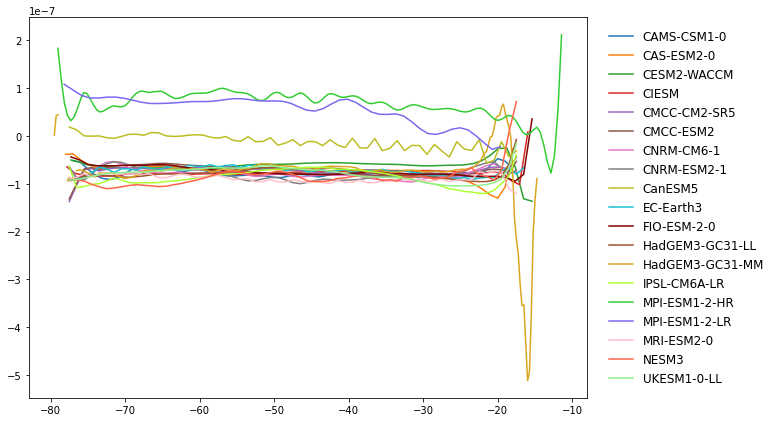

In [2]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'historical'

#Change time to date
outfile = ('/home/users/jordi/section26data/' + totmod[6] + '_' + EXP + '_' + ENS[6] + '.nc')  #CNRM-CM6-1 has gregorian calendar, which is supported by python datetime objects
ncid    = Dataset(outfile,'r')
time    = ncid.variables['time'][-129::]
units   = ncid.variables['time'].units
cal     = ncid.variables['time'].calendar
ncid.close()

tdate_hist   = cftime.num2pydate(time,units)

plt.figure(1,figsize=(10,7))
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','tomato','lightgreen'])
std = np.zeros(len(totmod))
wsc_histmean = np.zeros((len(totmod),129))
for i in range(len(totmod)):    
    outfile = ('/home/users/jordi/wind_stress_curl/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    wsc10   = ncid.variables['wsc10'][:,:]
    ncid.close()
    
    outfile1 = ('/home/users/jordi/section26data/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid = Dataset(outfile1,'r')
    lon  = np.squeeze(ncid.variables['lon'][:,:])
    ncid.close()
    
    #Correct lon for Atlantic shift
    if totmod[i] in ['CESM2-WACCM','CIESM','FIO-ESM-2-0']:
        lon = lon - 100
    
    #Find first and last unmasked grid cells
    x = np.nanmean(wsc10,axis=0)
    x1 = np.nonzero(x)
    
    plt.plot(lon[(np.min(x1)+1):(np.max(x1)-1)],np.nanmean(wsc10[:,(np.min(x1)+1):(np.max(x1)-1)],axis=0),label=totmod[i])  
    
    wsc_histmean[i,:] = np.nanmean(wsc10[:,(np.min(x1)+1):(np.max(x1)-1)],axis=1)
    std[i] = np.std(np.nanmean(wsc10[:,(np.min(x1)+1):(np.max(x1)-1)],axis=0))
    print(str(totmod[i]) + '   ' + str(std[i]))
          
plt.legend(loc='center left',bbox_to_anchor=(1.02, 0.5),prop={'size': 12},frameon=False)
print('Ensemble mean std = ' + str(np.nanmean(std)) )

#### SSP585

##### Write to file

In [4]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'ssp585'

for i in range(len(totmod)):
    print('Computing file ' + str(i+1) + ' of ' + str(len(totmod)))
    model   = Clist[totmod[i]]
    VFiles = model.getFiles('vo',    EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    WUFiles = model.getFiles('tauuo',EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    WVFiles  = model.getFiles('tauvo',EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn') 
          
    ncid = Dataset(WUFiles[0],'r')
    tauuo = ncid.variables['tauuo'][:]
    ncid.close()
        
    ncid = Dataset(WVFiles[0],'r')
    tauvo = ncid.variables['tauvo'][:]
    ncid.close()    
    
    if totmod[i] in ['CIESM','HadGEM3-GC31-LL','UKESM1-0-LL']:
        ncid = Dataset(WUFiles[1],'r')
        tauuo2 = ncid.variables['tauuo'][:]
        ncid.close()
        tauuo  = np.append(tauuo,tauuo2,axis=0)        
        
        ncid = Dataset(WVFiles[1],'r')
        tauvo2 = ncid.variables['tauvo'][:]
        ncid.close() 
        tauvo  = np.append(tauvo,tauvo2,axis=0)
        
        tauuo = np.ma.masked_where(tauuo>1000,tauuo)
        tauvo = np.ma.masked_where(tauvo>1000,tauvo)
        
    if totmod[i] in ['HadGEM3-GC31-MM','MPI-ESM1-2-LR']:
        for k in range(4):
            ncid = Dataset(WUFiles[k+1],'r')
            tauuo2 = ncid.variables['tauuo'][:]
            tauuo  = np.append(tauuo,tauuo2,axis=0)
            ncid.close() 

            ncid = Dataset(WVFiles[k+1],'r')
            tauvo2 = ncid.variables['tauvo'][:]
            tauvo  = np.append(tauvo,tauvo2,axis=0)
            ncid.close()   
               
        tauuo = np.ma.masked_where(tauuo>1000,tauuo)
        tauvo = np.ma.masked_where(tauvo>1000,tauvo)
        
    if totmod[i] == 'MPI-ESM1-2-HR':
        for k in range(17):
            ncid = Dataset(WUFiles[k+1],'r')
            tauuo2 = ncid.variables['tauuo'][:]
            tauuo  = np.append(tauuo,tauuo2,axis=0)
            ncid.close() 

            ncid = Dataset(WVFiles[k+1],'r')
            tauvo2 = ncid.variables['tauvo'][:]
            tauvo  = np.append(tauvo,tauvo2,axis=0)
            ncid.close()   
               
        tauuo = np.ma.masked_where(tauuo>1000,tauuo)
        tauvo = np.ma.masked_where(tauvo>1000,tauvo)

    if totmod[i] == 'EC-Earth3':
        for k in range(85):
            ncid = Dataset(WUFiles[k+1],'r')
            tauuo2 = ncid.variables['tauuo'][:]
            tauuo  = np.append(tauuo,tauuo2,axis=0)
            ncid.close() 

            ncid = Dataset(WVFiles[k+1],'r')
            tauvo2 = ncid.variables['tauvo'][:]
            tauvo  = np.append(tauvo,tauvo2,axis=0)
            ncid.close()   
               
        tauuo = np.ma.masked_where(tauuo>1000,tauuo)
        tauvo = np.ma.masked_where(tauvo>1000,tauvo)
        
    # Read in grid information:
    ncid = Dataset(VFiles[0],'r')
    if model.Oreg:
        lon  = ncid.variables[model.Olon][:]
        lat  = ncid.variables[model.Olat][:]
        lon,lat = np.meshgrid(lon,lat)
    else:
        lon  = ncid.variables[model.Olon][:,:]
        lat  = ncid.variables[model.Olat][:,:]
    ncid.close()
    
    mesh_mask = ('/home/users/jordi/mesh_masks/' + model.name + '_mesh_mask.nc')
    ncid = Dataset(mesh_mask,'r')
    vmask = np.squeeze(ncid.variables['vmask'][:,:,:,:])
    dx   = ncid.variables['dxv'][:,:]              
    dy   = ncid.variables['dyv'][:,:]   
    ncid.close()
    
    if model.OflipNS == True:
        mesh_mask = ('/home/users/jordi/mesh_masks/' + model.name + '_mesh_mask.nc')
        ncid = Dataset(mesh_mask,'r')
        vmask = np.flip(np.squeeze(ncid.variables['vmask'][:,:,:,:]),axis=1)
        dx   = np.flip(ncid.variables['dxv'][:,:],axis=0)              
        dy   = np.flip(ncid.variables['dyv'][:,:],axis=0)
        ncid.close()        
            
    #Find lat and lon indices
    alat = 26.5                           
    mlat = np.mean(lat,axis=1)
    ilat = np.argmin(np.abs(mlat-alat))
    
    lon[np.where(lon>180)] = lon[np.where(lon>180)] - 360
    alon_min = -80
    alon_max = -10
    ilon_min = np.argmin(np.abs(lon[ilat,:]-alon_min))
    ilon_max = np.argmin(np.abs(lon[ilat,:]-alon_max))

    #Shift Atlantic if necessary
    if model.name in ['CESM2-WACCM','CIESM','FIO-ESM-2-0']:
        tauuo = np.roll(tauuo[:,:,:],90,axis=-1)
        tauvo = np.roll(tauvo[:,:,:],90,axis=-1)
        vmask[:,:,:] = np.roll(vmask[:,:,:],90,axis=2)
        dx  = np.roll(dx,90,axis=-1)
        dy  = np.roll(dy,90,axis=-1)
        ilon_min = ilon_min + 90
        ilon_max = ilon_max + 90

        #Make sure the min and max fall within the mask longitudes
        if ilon_min > len(lon[0,:]):
            ilon_min = ilon_min - len(lon[0,:])
        elif ilon_min < 0:
                ilon_min = len(lon[0,:]) + ilon_min

        if ilon_max > len(lon[0,:]):
            ilon_max = ilon_max - len(lon[0,:])
        elif ilon_max < 0:
                ilon_max = len(lon[0,:]) + ilon_max 
        
    #Manual change in ilon and ilat
    if model.name in ['CESM2-WACCM','FIO-ESM-2-0']:
        ilat = ilat + 3
        ilon_min = ilon_min - 1
    elif model.name == 'CIESM':
        ilat = ilat + 3
        ilon_min = ilon_min - 2
    elif model.name in ['CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','EC-Earth3']:
        ilon_min = ilon_min - 1     
        ilon_max = ilon_max + 1       
    elif model.name in ['CanESM5','HadGEM3-GC31-LL','NESM3','UKESM1-0-LL']:
        ilon_min = ilon_min - 1        
    elif model.name == 'HadGEM3-GC31-MM':
        ilon_min = ilon_min - 2    
    elif model.name == 'IPSL-CM6A-LR':
        ilon_min = ilon_min - 1
        ilon_max = ilon_max - 1           
    elif model.name == 'MPI-ESM1-2-HR':
        ilat = ilat - 4
        ilon_min = ilon_min - 1
        ilon_max = ilon_max + 3           
    elif model.name == 'MPI-ESM1-2-LR':
        ilat = ilat - 8
        ilon_min = ilon_min - 3
        ilon_max = ilon_max - 1   
        
    #plt.figure(i,figsize=(10,7))
    #plt.title(totmod[i])
    #if model.OextraWE == [1, 1]:
    #    plt.pcolormesh(1-tauuo[0,:,1:-1].mask+2*vmask[0,:,:])
    #else:
    #    plt.pcolormesh(1-tauuo[0,:,:].mask+2*vmask[0,:,:])
                
    #Correct for halo points
    if model.OextraWE == [1, 1]:
        vmask  = vmask[0,ilat,ilon_min-1:ilon_max-1]
        dx   = dx[ilat,ilon_min-1:ilon_max-1]
        dy   = dy[ilat,ilon_min-1:ilon_max-1]    
    else:
        vmask  = vmask[0,ilat,ilon_min:ilon_max]
        dx   = dx[ilat,ilon_min:ilon_max]
        dy   = dy[ilat,ilon_min:ilon_max]
    
    #plt.figure(i)
    #plt.title(totmod[i])
    #plt.pcolormesh(tauuo[-1,:,:])
    #plt.axhline(y=ilat,color='C3')
    #plt.axvline(x=ilon_min,color='C2')
    #plt.axvline(x=ilon_max,color='C0')
    #plt.colorbar()

    #plt.figure(i+1)
    #plt.title(totmod[i])
    #plt.pcolormesh(tauvo[-1,:,:])
    #plt.axhline(y=ilat,color='C3')
    #plt.axvline(x=ilon_min,color='C2')
    #plt.axvline(x=ilon_max,color='C0')
    #plt.colorbar()
    
    time = 85*12
    #Obtain all surrounding grid cells which are used for averaging
    tauuo_up       = tauuo[0:time,ilat+1,ilon_min:ilon_max]
    tauuo_down     = tauuo[0:time,ilat-1,ilon_min:ilon_max]
    tauuo_right    = np.roll(tauuo[0:time,ilat,:],-1,axis=-1)[:,ilon_min:ilon_max]
    tauuo_left     = np.roll(tauuo[0:time,ilat,:],1,axis=-1)[:,ilon_min:ilon_max]
    tauuo_upleft   = np.roll(tauuo[0:time,ilat+1,:],1,axis=-1)[:,ilon_min:ilon_max]
    tauuo_downleft = np.roll(tauuo[0:time,ilat-1,:],1,axis=-1)[:,ilon_min:ilon_max]
    tauuo          = tauuo[0:time,ilat,ilon_min:ilon_max]

    tauvo_up     = tauvo[0:time,ilat+1,ilon_min:ilon_max]
    tauvo_down   = tauvo[0:time,ilat-1,ilon_min:ilon_max]
    tauvo_right  = np.roll(tauvo[0:time,ilat,:],-1,axis=-1)[:,ilon_min:ilon_max]
    tauvo_left   = np.roll(tauvo[0:time,ilat,:],1,axis=-1)[:,ilon_min:ilon_max]
    tauvo        = tauvo[0:time,ilat,ilon_min:ilon_max]
    
    #plt.figure(i+2)
    #plt.title(totmod[i])
    #plt.pcolormesh(tauuo)
    #plt.colorbar()
    
    #plt.figure()
    #plt.title(totmod[i])
    #plt.pcolormesh(tauvo)
    #plt.colorbar()
    
    #All B-grids have the same averaging, C-grids vary
    if model.Ogrid in ['Btr','Bbl']:
        du = (tauuo_up + tauuo)/2 - (tauuo_down + tauuo)/2
        dv = (tauvo_right + tauvo)/2 - (tauvo_left + tauvo)/2       
        wsc = dv/dx[None,:] - du/dy[None,:]                            #None is included to divide a 2D array by a 1D array
    elif model.Ogrid == 'Ctr':
        du = (tauuo_up + tauuo_upleft)/2 - (tauuo + tauuo_left)/2
        dv = (tauvo_right + tauvo)/2 - (tauvo_left + tauvo)/2        
        wsc = dv/dx[None,:] - du/dy[None,:] 
    elif model.Ogrid == 'Cbr':
        du = (tauuo + tauuo_left)/2 - (tauuo_down + tauuo_downleft)/2
        dv = (tauvo_right + tauvo)/2 - (tauvo_left + tauvo)/2       
        wsc = dv/dx[None,:] - du/dy[None,:]  
    
    #Write to file
    outfile = ('/home/users/jordi/wind_stress_curl/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid = Dataset(outfile,'w')
    ncid.createDimension('time', time)
    ncid.createDimension('lon' , ilon_max-ilon_min)
    
    ncid.createVariable('wsc10','f8',('time','lon',))
    ncid.variables['wsc10'][:]       = wsc
    ncid.close()

Computing file 1 of 4
Computing file 2 of 4
Computing file 3 of 4
Computing file 4 of 4


##### Plot results

CAMS-CSM1-0   1.0152367015164408e-08
CAS-ESM2-0   1.4364472589721377e-08
CESM2-WACCM   1.4689830570585952e-08
CIESM   1.3398357843747543e-08
CMCC-CM2-SR5   1.2083698697970591e-08
CMCC-ESM2   1.0592367890112209e-08
CNRM-CM6-1   9.438628269128093e-09
CanESM5   1.5682040553250482e-08
EC-Earth3   7.903577751730192e-09
FIO-ESM-2-0   1.7685861134596922e-08
HadGEM3-GC31-LL   1.417741298935433e-08
HadGEM3-GC31-MM   7.641108296910896e-08
IPSL-CM6A-LR   1.3718260520468041e-08
MPI-ESM1-2-HR   2.9666535506354176e-08
MPI-ESM1-2-LR   3.366078777635375e-08
MRI-ESM2-0   7.53557012297775e-09
NESM3   1.5492807980086332e-08
UKESM1-0-LL   1.5047069521864666e-08
Ensemble mean std = 1.8427818316809764e-08


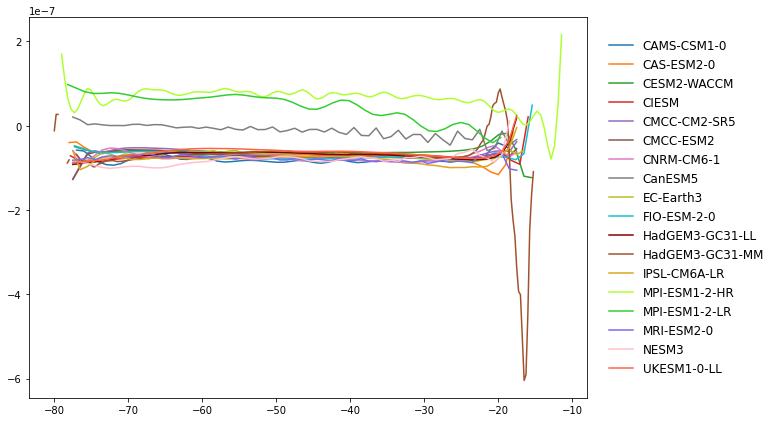

In [3]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'ssp585'

#Change time to date
outfile = ('/home/users/jordi/section26data/' + totmod[0] + '_' + EXP + '_' + ENS[0] + '.nc')   #First model data: 2015-01-16 - 2099-12-16
ncid    = Dataset(outfile,'r')
time    = ncid.variables['time'][:]
ncid.close()

tdate_ssp = pd.to_datetime(time,unit='D',origin=pd.Timestamp('2015-01-16'))

plt.figure(1,figsize=(10,7))
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','tomato','lightgreen'])
std = np.zeros(len(totmod))
wsc_sspmean = np.zeros((len(totmod),85*12))
for i in range(len(totmod)):    
    outfile = ('/home/users/jordi/wind_stress_curl/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    wsc10   = ncid.variables['wsc10'][:,:]
    ncid.close()
    
    outfile1 = ('/home/users/jordi/section26data/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid = Dataset(outfile1,'r')
    lon  = np.squeeze(ncid.variables['lon'][:,:])
    ncid.close()
    
    #Correct lon for Atlantic shift
    if totmod[i] in ['CESM2-WACCM','CIESM','FIO-ESM-2-0']:
        lon = lon - 100
    
    #Find first and last unmasked grid cells
    x = np.nanmean(wsc10,axis=0)
    x1 = np.nonzero(x)
    
    plt.plot(lon[(np.min(x1)+1):(np.max(x1)-1)],np.nanmean(wsc10[:,(np.min(x1)+1):(np.max(x1)-1)],axis=0),label=totmod[i])  
    
    wsc_sspmean[i,:] = np.nanmean(wsc10[:,(np.min(x1)+1):(np.max(x1)-1)],axis=1)
    std[i] = np.std(np.nanmean(wsc10[:,(np.min(x1)+1):(np.max(x1)-1)],axis=0))
    
    print(str(totmod[i]) + '   ' + str(std[i]))
          
plt.legend(loc='center left',bbox_to_anchor=(1.02, 0.5),prop={'size': 12},frameon=False)
print('Ensemble mean std = ' + str(np.nanmean(std)) )

#### Compare historical and ssp585 ensemble mean time series

Historical     -5.953973375019742e-08
SSP585         -5.501882491295559e-08
SSP585 90-99   -5.09810052997501e-08
-14.374818144730016


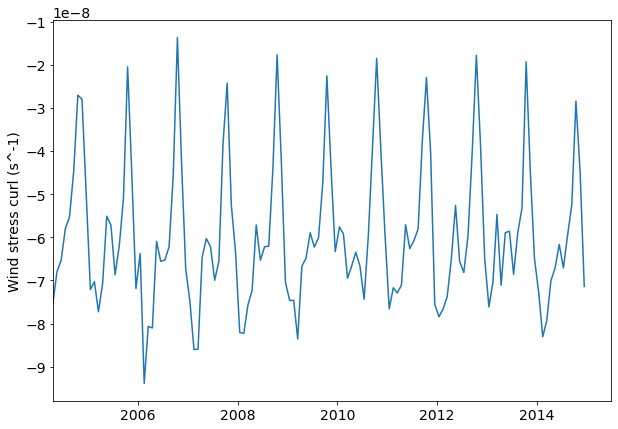

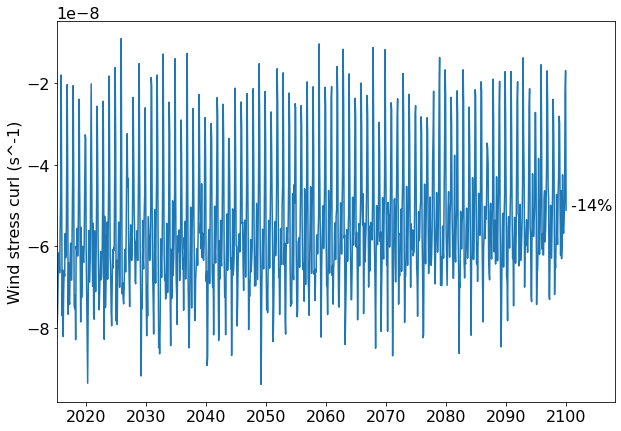

In [7]:
print('Historical     ' +  str(np.nanmean(wsc_histmean)))
print('SSP585         ' + str(np.nanmean(wsc_sspmean)))
print('SSP585 90-99   ' + str(np.nanmean(wsc_sspmean[:,-10*12::])))

#Compute decline of last decade of SSP585 compared to historical mean
dcl = 100*(np.nanmean(wsc_sspmean[:,-10*12::]) - np.nanmean(wsc_histmean))/np.nanmean(wsc_histmean)
print(dcl)

#Plot historical ensemble mean time series
fig,ax = plt.subplots(figsize=(10,7))
plt.plot(tdate_hist,np.nanmean(wsc_histmean,axis=0))
plt.ylabel('Wind stress curl (s^-1)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=tdate_hist[0])
ax.yaxis.get_offset_text().set_fontsize(14)

#Plot SSP585 ensemble mean time series
fig,ax = plt.subplots(figsize=(10,7))
plt.plot(tdate_ssp,np.nanmean(wsc_sspmean,axis=0))
plt.ylabel('Wind stress curl (s^-1)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.text(tdate_ssp[-1],np.nanmean(wsc_sspmean[:,-10*12::]),' ' + str(int(dcl)) + '%',fontsize=16)    #Add decline to graph
plt.xlim(left=tdate_ssp[0],right=pd.Timestamp('2108-01-16'))
ax.yaxis.get_offset_text().set_fontsize(16)

#### Check length wind stress files

In [49]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
ENSar  = ['r2i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1',
           'r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'ssp585'

for i in range(len(totmod)):
    model   = Clist[totmod[i]]
    WUFiles = model.getFiles('tauuo',EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    print(str(totmod[i]) + ' - ' + str(len(WUFiles)))
    WVFiles  = model.getFiles('tauvo',EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    print(str(totmod[i]) + ' - ' + str(np.shape(WVFiles)))   
    
    if model.name in ['CESM2-WACCM','CIESM','CanESM5','EC-Earth3','HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','UKESM1-0-LL']:
        print(WUFiles[-1])

CAMS-CSM1-0 - 1
CAMS-CSM1-0 - (1,)
CAS-ESM2-0 - 1
CAS-ESM2-0 - (1,)
CESM2-WACCM - 5
CESM2-WACCM - (5,)
/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Omon/tauuo/gn/latest/tauuo_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc
CIESM - 2
CIESM - (2,)
/badc/cmip6/data/CMIP6/ScenarioMIP/THU/CIESM/ssp585/r1i1p1f1/Omon/tauuo/gn/latest/tauuo_Omon_CIESM_ssp585_r1i1p1f1_gn_206501-210012.nc
CMCC-CM2-SR5 - 1
CMCC-CM2-SR5 - (1,)
CMCC-ESM2 - 1
CMCC-ESM2 - (1,)
CNRM-CM6-1 - 1
CNRM-CM6-1 - (1,)
CanESM5 - 3
CanESM5 - (3,)
/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Omon/tauuo/gn/latest/tauuo_Omon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
EC-Earth3 - 86
EC-Earth3 - (86,)
/badc/cmip6/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp585/r1i1p1f1/Omon/tauuo/gn/latest/tauuo_Omon_EC-Earth3_ssp585_r1i1p1f1_gn_210001-210012.nc
FIO-ESM-2-0 - 1
FIO-ESM-2-0 - (1,)
HadGEM3-GC31-LL - 2
HadGEM3-GC31-LL - (2,)
/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/HadGEM3-GC31